## Getting Started with Cantemist

## Preparation

Go to the root folder of the repository and run the following commands

`xmen dict examples/conf/cantemist.yaml --code examples/dicts/cantemist.py`


This command creates the Cantemist- ICD-O jsonl file.

`xmen index examples/conf/cantemist.yaml --all`

This command creates the indices used candidate generations (both TF-IDF and SapBERT).

By default, all files are written to `~/.cache/xmen`, unless configured otherwise.

In [1]:
#xmen index C:\Users\Daniela\xmen\examples\conf\cantemist.yaml --all

In [9]:
#!git clone https://github.com/bigscience-workshop/biomedical

Cloning into 'biomedical'...
remote: Enumerating objects: 6800, done.
remote: Counting objects: 100% (1491/1491), done.
remote: Compressing objects: 100% (946/946), done.
remote: Total 6800 (delta 685), reused 1300 (delta 537), pack-reused 5309
Receiving objects: 100% (6800/6800), 26.03 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (3435/3435), done.
Updating files: 100% (1012/1012), done.


## Loading Knowledge Base and Dataset

In [ ]:
#variant = "cantemist"

In [2]:
from pathlib import Path
#base_path = Path.home() / f".cache/xmen/{variant}"
base_path = Path.home() / ".cache/xmen/cantemist"

In [3]:
#print(base_path)

In [4]:
#!pip install ./biomedical/

In [5]:
# Load cantemist subset through BigBIO dataloader
from datasets import load_dataset
#dataset = load_dataset("bigbio/cantemist", "cantemist_bigbio_kb",download_mode="force_redownload")
dataset = load_dataset('./biomedical/bigbio/biodatasets/cantemist/cantemist.py', 'cantemist_bigbio_kb', 'trust_remote_code=True')

/dhc/home/daniela.perezcespede/conda3/envs/xmen/lib/python3.10/site-packages/datasets/load.py:929: FutureWarning: The repository for cantemist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at ./biomedical/bigbio/biodatasets/cantemist/cantemist.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 501
    })
    test: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 300
    })
    validation: Dataset({
        features: ['id', 'document_id', 'passages', 'entities', 'events', 'coreferences', 'relations'],
        num_rows: 500
    })
})

In [7]:
from xmen import load_kb
#kb = load_kb(base_path / f"{variant}.jsonl")
kb = load_kb(base_path / "cantemist.jsonl")

In [8]:
missing_codes = list()
for d in dataset['train']:
    for e in d['entities']:
        for code in e['normalized']:
            id = code['db_id']
            if not id in kb.cui_to_entity:
                missing_codes.append(id)
len(missing_codes), len(set(missing_codes))

(0, 0)

In [9]:
missing_codes

[]

# Candidate Generation

We use the pre-computed indices to retrieve the 64 most similar concepts for each mention

In [10]:
# Generate candidates with Ensemble of TF-IDF + SapBERT
from xmen.linkers import default_ensemble
linker = default_ensemble(base_path / "index")

/dhc/home/daniela.perezcespede/conda3/envs/xmen/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[06/28/24 10:02:40] INFO     Loading hierarchical faiss index                                ]8;id=333234;file:///dhc/home/daniela.perezcespede/conda3/envs/xmen/lib/python3.10/site-packages/xmen/linkers/sap_bert_linker.py\sap_bert_linker.py]8;;\:]8;id=342437;file:///dhc/home/daniela.perezcespede/conda3/envs/xmen/lib/python3.10/site-packages/xmen/linkers/sap_bert_linker.py#153\153]8;;\

                    INFO     Loading index from                                                 ]8;id=615869;file:///dhc/home/daniela.perezcespede/conda3/envs/xmen/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=643206;file:///dhc/home/daniela.perezcespede/conda3/envs/xmen/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py#64\64]8;;\
                             /dhc/home/daniela.perezcespede/.cache/xmen/cantemist/index/sapbert                    
                             /embed_faiss_hier.pickle                                                              

                    INFO     Loaded index of type <class 'faiss.swigfaiss.IndexHNSWFlat'> and   ]8;id=490013;file:///dhc/home/daniela.perezcespede/conda3/envs/xmen/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py\faiss_indexer.py]8;;\:]8;id=310126;file:///dhc/home/daniela.perezcespede/conda3/envs/xmen/lib/python3.10/site-packages/xmen/linkers/faiss_indexer.py#66\66]8;;\
                             size 15100                                                                            

In [11]:
candidates = linker.predict_batch(dataset["test"], top_k=64, batch_size=128)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [12]:
#When the score is below the CUTOFF, then associate the term to the generic code 8000/6 (Neoplasia metastásica)
CUTOFF = 0.8

def add_manual_concepts(document):
    entities = []
    for e in document["entities"]:
        norm = e["normalized"]
        if norm[0]["score"] < CUTOFF:
            norm.insert(0,
                {'db_id': '8000/6',
                 'db_name': 'UMLS',
                 'score': 1.0,
                 'predicted_by': ['manual']})
        entities.append(e)
    return {"entities" : entities}

In [13]:
candidates_manual = candidates.map(lambda d: add_manual_concepts(d))

In [77]:
#linker.predict_no_context(["mesenquimal"])

In [14]:
from xmen.evaluation import evaluate
evaluate(dataset['test'], candidates_manual, top_k_predictions=1)

{'strict': {'precision': 0.5205064684833471,
  'recall': 0.5202200825309491,
  'fscore': 0.5203632361034674,
  'ptp': 1891,
  'fp': 1742,
  'rtp': 1891,
  'fn': 1744,
  'n_docs_system': 300,
  'n_annos_system': 3635,
  'n_docs_gold': 300,
  'n_annos_gold': 3635}}

In [15]:
from xmen.evaluation import evaluate_at_k
_ = evaluate_at_k(dataset['test'], candidates_manual)

Recall@1 0.5202200825309491
Recall@2 0.5972489683631361
Recall@4 0.7832187070151306
Recall@8 0.8442916093535076
Recall@16 0.8781292984869326
Recall@32 0.9056396148555709
Recall@64 0.9169188445667125


In [22]:
from xmen.evaluation import error_analysis

# Before re-ranking
ea_df = error_analysis(dataset['test'], candidates_manual, tasks=['nen'])

In [31]:
ea_df
#convert into csv file:
#ea_df.to_csv('all_errors', sep=',', index=False, encoding='utf-8')

,_word_len,_abbrev,gt_start,gt_end,gt_text,gold_type,gold_concept,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,1,False,1108,1118,[metástasis],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/6'}",0,0.818870,8000/6,0.818870,cc_onco1206
1,1,False,2320,2330,[metástasis],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/6'}",0,0.818870,8000/6,0.818870,cc_onco1206
2,1,False,2545,2555,[tumoración],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/1'}",4,0.630540,8000/6,1.000000,cc_onco1206
3,3,False,2625,2652,[carcinoma adenoide quístico],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8200/3'}",0,1.000000,8200/3,1.000000,cc_onco1206
4,1,False,2685,2695,[tumoración],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/1'}",4,0.630540,8000/6,1.000000,cc_onco1206
...,...,...,...,...,...,...,...,...,...,...,...,...
3630,1,False,2761,2771,[tumoración],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/1'}",4,0.630540,8000/6,1.000000,cc_onco1120
3631,1,False,3131,3141,[tumoración],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/1'}",4,0.630540,8000/6,1.000000,cc_onco1120
3632,1,False,3215,3225,[tumoración],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/1'}",4,0.630540,8000/6,1.000000,cc_onco1120
3633,3,False,3229,3264,[Tumor miofibroblástico inflamatorio],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8825/1'}",0,0.800722,8825/1,0.800722,cc_onco1120


In [26]:
ea_df.query("pred_index == -1")

,_word_len,_abbrev,gt_start,gt_end,gt_text,gold_type,gold_concept,pred_index,pred_index_score,pred_top,pred_top_score,document_id
22,6,False,3158,3196,[carcinoma medular tiroideo pT4a pN1 M1],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8510/6'}",-1,NaN,8000/6,1.000000,cc_onco1485
33,8,False,283,340,"[adenocarcinoma de próstata en lóbulo derecho,...",MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8140/31'}",-1,NaN,8000/6,1.000000,cc_onco1453
42,1,False,598,613,[sólido-quística],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8452/1'}",-1,NaN,8000/6,1.000000,cc_onco855
43,1,True,739,743,[GIST],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8936/3'}",-1,NaN,8000/6,1.000000,cc_onco855
49,3,True,2784,2810,"[GIST, variante epitelioide]",MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8936/3/H'}",-1,NaN,8000/6,1.000000,cc_onco855
...,...,...,...,...,...,...,...,...,...,...,...,...
3511,4,False,1361,1389,[neoplasia de células grandes],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/1/H'}",-1,NaN,8003/3,0.827786,cc_onco1242
3526,6,False,2238,2290,[metástasis de tumor neuroendocrino bien difer...,MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8240/6'}",-1,NaN,8000/6,1.000000,cc_onco659
3530,6,False,4576,4628,[metástasis de tumor neuroendocrino bien difer...,MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8240/6'}",-1,NaN,8000/6,1.000000,cc_onco659
3532,9,False,5268,5342,[tumor neuroendocrino de probable origen intes...,MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8240/6'}",-1,NaN,8000/6,1.000000,cc_onco659


In [27]:
#Check when it was assigned the generic code 8000/6, but the match was better with another ICD-O code
ea_df[ea_df.gold_concept.map(lambda g: g["db_id"] == "8000/6") & (ea_df.pred_index == -1)]#.pred_index.value_counts()

,_word_len,_abbrev,gt_start,gt_end,gt_text,gold_type,gold_concept,pred_index,pred_index_score,pred_top,pred_top_score,document_id
3329,5,False,7134,7159,[enfermedad a nivel de SNC],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/6'}",-1,NaN,9701/3,0.820186,cc_onco1038


# Reranking

## Using a Pre-trained Model for Reranking

When no are little annotated training data is available, a pre-trained model can provide good re-ranking performance.
Here, we use a cross-encoder that was trained on an automatically translated version of MedMentions (see the notebook [01_Translation.ipynb](01_Translation.ipynb))

In [80]:
#from xmen.reranking.cross_encoder import *
#ce_dataset = CrossEncoderReranker.prepare_data(candidates_manual, dataset["test"], kb)

In [81]:
# CE re-ranker, pre-trained on Spanish translation of MedMentions
#rr = CrossEncoderReranker.load("phlobo/xmen-es-ce-medmentions", device=0)

In [82]:
# Predict on test set
#prediction = rr.rerank_batch(candidates_manual, ce_dataset, allow_nil=False)

In [83]:
#evaluate(dataset['test'], prediction)

## Training a Fully-supervised Model

Finally, with enough training data, we can also train a fully supervsied cross-encoder to learn a better task-specific ranking.

The cross-encoder is trained with batches of 64 candidates. 
We keep the checkpoint that maximizes accuracy@1 on the validation set.

In [84]:
candidates_all = linker.predict_batch(dataset, top_k=64, batch_size=128)

Map:   0%|          | 0/501 [00:00<?, ? examples/s]


KeyboardInterrupt



In [ ]:
candidates_manual_all = candidates_all.map(lambda d: add_manual_concepts(d))

In [ ]:
from xmen.reranking.cross_encoder import *
ce_dataset_all = CrossEncoderReranker.prepare_data(candidates_manual_all, dataset, kb)

In [17]:
# Train the cross-encoder on the training set and use the validation set for model selection
rr_fs = CrossEncoderReranker()
# Note: we train for 3 epochs only (you likely want to increase this for better performance)
args = CrossEncoderTrainingArgs(num_train_epochs=3, model_name="PlanTL-GOB-ES/roberta-base-biomedical-clinical-es")
rr_fs.fit(args, ce_dataset_all["train"].dataset, ce_dataset_all["validation"].dataset, show_progress_bar=True)

model_name := bert-base-multilingual-cased
num_train_epochs := 3
fp16 := True
label_smoothing := False
rank_regularization := 1.0
train_layers := None
softmax_loss := True
random_seed := 42
learning_rate := 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2023-10-18 13:49:28 - Use pytorch device: cuda
2023-10-18 14:08:02 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 0:
2023-10-18 14:18:57 - Accuracy: 0.7233468286099866
2023-10-18 14:18:57 - Accuracy @ 5: 0.861336032388664
2023-10-18 14:18:57 - Accuracy @ 64: 0.9946018893387314
2023-10-18 14:18:57 - Baseline Accuracy: 0.6686909581646424
2023-10-18 14:18:57 - Save model to ./output/cross_encoder
2023-10-18 14:37:28 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 1:
2023-10-18 14:48:25 - Accuracy: 0.7435897435897436
2023-10-18 14:48:25 - Accuracy @ 5: 0.8711201079622132
2023-10-18 14:48:25 - Accuracy @ 64: 0.9946018893387314
2023-10-18 14:48:25 - Baseline Accuracy: 0.6686909581646424
2023-10-18 14:48:25 - Save model to ./output/cross_encoder
2023-10-18 15:07:04 - EntityLinkingEvaluator: Evaluating the model on eval dataset after epoch 2:
2023-10-18 15:18:02 - Accuracy: 0.7510121457489879
2023-10-18 15:18:02 - Accuracy @ 5: 0.873481781

In [18]:
# Predict on test set
prediction_fs = rr_fs.rerank_batch(candidates_manual_all["test"], ce_dataset_all["test"])

Batches:   0%|          | 0/3095 [00:00<?, ?it/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

Map:   0%|          | 0/833 [00:00<?, ? examples/s]

In [ ]:
evaluate(dataset['test'], prediction_fs)

# Evaluation

## Metrics

We compute metrics for the predicted concepts vs. the gold-standard for different values of k

In [19]:
evaluate(dataset['test'], prediction_fs)

{'strict': {'precision': 0.7528015820698748,
  'recall': 0.7377260981912145,
  'fscore': 0.7451876019575857,
  'ptp': 2284,
  'fp': 750,
  'rtp': 2284,
  'fn': 812,
  'n_docs_system': 833,
  'n_annos_system': 3034,
  'n_docs_gold': 833,
  'n_annos_gold': 3097}}

In [20]:
from xmen.evaluation import evaluate_at_k
_ = evaluate_at_k(dataset['test'], candidates['test'])

Recall@1 0.6595607235142119
Recall@2 0.790374677002584
Recall@4 0.8449612403100775
Recall@8 0.8656330749354005
Recall@16 0.8853359173126615
Recall@32 0.8963178294573644
Recall@64 0.8998708010335917


In [21]:
_ = evaluate_at_k(dataset['test'], prediction_fs)

Recall@1 0.7377260981912145
Recall@2 0.8049095607235142
Recall@4 0.8397932816537468
Recall@8 0.8601421188630491
Recall@16 0.8782299741602068
Recall@32 0.8888888888888888
Recall@64 0.8934108527131783


## Error Analysis

To gain more insights into the ranking errors (and potential NER errors, which do not apply here), we use the `error_analysis` functionality of xmen

,_word_len,_abbrev,gt_start,gt_end,gt_text,gold_type,gold_concept,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,1,False,794,806,[neoformación],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/1'}",0,0.745895,8000/1,0.745895,cc_onco1006
1,1,False,882,894,[metastásicas],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/6'}",246,0.271365,8312/6,0.866415,cc_onco1006
2,3,False,1115,1147,[adenocarcinoma bien diferenciado],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8140/31'}",0,1.000000,8140/31,1.000000,cc_onco1006
3,1,False,1590,1602,[neoformación],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/1'}",0,0.745895,8000/1,0.745895,cc_onco1006
4,1,False,1678,1690,[metastásicas],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/6'}",246,0.271365,8312/6,0.866415,cc_onco1006
5,3,False,1911,1943,[adenocarcinoma bien diferenciado],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8140/31'}",0,1.000000,8140/31,1.000000,cc_onco1006
6,5,False,2121,2166,"[adenocarcinoma de sigma estenosante, pT3N2bM1]",MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8140/6'}",4,0.568437,9062/6,0.624968,cc_onco1006
7,2,False,2172,2191,[afectación hepática],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/6'}",3,0.572814,9735/6,0.706308,cc_onco1006
8,1,False,2347,2352,[tumor],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/1'}",0,0.950313,8000/1,0.950313,cc_onco1006
9,1,False,2494,2504,[metástasis],MORFOLOGIA_NEOPLASIA,"{'db_name': 'eCIE-O-3.1', 'db_id': '8000/6'}",165,0.309242,8973/6,0.970318,cc_onco1006


In [24]:
# After Re-Ranking
ea_df = error_analysis(dataset['test'], prediction_fs, tasks=['nen'])
ea_df.head(10)

,_word_len,_abbrev,gt_start,gt_end,gt_text,gold_concept,gold_type,pred_index,pred_index_score,pred_top,pred_top_score,document_id
0,1,False,0,5,[Etude],"{'db_name': 'UMLS', 'db_id': 'C0008972'}",PROC,-1,NaN,NIL,NaN,1009657
1,1,False,47,55,[Africain],"{'db_name': 'UMLS', 'db_id': 'C0027567'}",LIVB,1,0.037805,C0085756,0.041022,1009657
2,1,False,4,13,[gangrènes],"{'db_name': 'UMLS', 'db_id': 'C0017086'}",DISO,0,0.042884,C0017086,0.042884,1009808
3,2,False,4,22,[gangrènes gazeuses],"{'db_name': 'UMLS', 'db_id': 'C0017105'}",DISO,0,0.061593,C0017105,0.061593,1009808
4,1,False,14,22,[gazeuses],"{'db_name': 'UMLS', 'db_id': 'C0017110'}",CHEM,0,0.090157,C0017110,0.090157,1009808
5,1,False,35,46,[tuberculose],"{'db_name': 'UMLS', 'db_id': 'C0041296'}",DISO,0,0.04742,C0041296,0.04742,1019393
6,2,False,35,53,[tuberculose bovine],"{'db_name': 'UMLS', 'db_id': 'C0041307'}",DISO,0,0.062842,C0041307,0.062842,1019393
7,1,False,47,53,[bovine],"{'db_name': 'UMLS', 'db_id': 'C0007452'}",LIVB,0,0.087439,C0007452,0.087439,1019393
8,2,False,56,75,[Mycobacterium bovis],"{'db_name': 'UMLS', 'db_id': 'C0026917'}",DISO,-1,NaN,C0041307,0.550823,1019393
9,1,False,78,86,[observés],"{'db_name': 'UMLS', 'db_id': 'C0302523'}",PROC,0,0.050934,C0302523,0.050934,1019393


<Axes: xlabel='pred_index'>

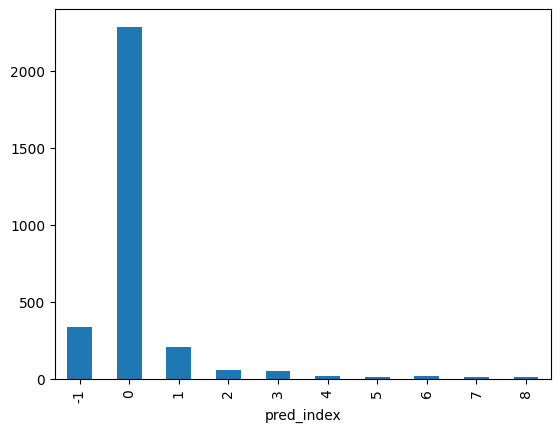

In [25]:
ea_df.pred_index.value_counts().sort_index().iloc[0:10].plot.bar()